## CIFAR 100 Dataset

In [1]:
# %%capture
# !pip install pytorch-lightning
# !pip install torchmetrics
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install einops

In [2]:
import torch
import torchvision
import torch.nn.functional as F
from torchvision.transforms import transforms
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
import pytorch_lightning as pl
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import torchmetrics
import torchvision.models as models
from tqdm.auto import tqdm
from einops.layers.torch import Rearrange
import cv2
import warnings
warnings.filterwarnings('ignore')
# pl.seed_everything(0xC0FFEE)
torch.manual_seed(0xC0FFEE)


# Load Dataset

In [3]:
path_to_data = '../raid/'

In [4]:
train_data = torchvision.datasets.CIFAR100(root=path_to_data,
                                             train=True,
                                             download=True,
                                             transform=transforms.ToTensor())

Files already downloaded and verified


In [5]:
loader = torch.utils.data.DataLoader(train_data, batch_size= 64, shuffle=False, num_workers=1)

In [6]:
mean = torch.tensor([0.5071, 0.4865, 0.4409])
std = torch.tensor([0.2009, 0.1984, 0.2023])

## Define Data Transforms & Augmentations

In [7]:
from torchvision.transforms.functional import rotate

train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize(size = (224, 224)),
                                      transforms.Normalize(mean, std),
                                    #   transforms.RandomHorizontalFlip(),
                                    #   transforms.RandomAffine(degrees=45, translate=(0.3, 0.3)),
                                      ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(size = (224, 224)),
                                     transforms.Normalize(mean, std)])

## Create Train, Val and Test Dataloaders

In [8]:
train_data = torchvision.datasets.CIFAR10(root=path_to_data,
                                           train=True,
                                           download=True,
                                           transform=train_transform)

# val_data = torchvision.datasets.CIFAR100(root=path_to_data,
#                                          train=True,
#                                          download=False,
#                                          transform=test_transform)


# val_count = round(len(train_data) * 0.05)
# train_count = len(train_data) - val_count

# train_data, _ = torch.utils.data.random_split(train_data, [train_count, val_count])
# _, val_data = torch.utils.data.random_split(val_data, [train_count, val_count])


test_data = torchvision.datasets.CIFAR10(root=path_to_data,
                                          train=False,
                                          download=True,
                                          transform = test_transform)

classes = train_data.classes

print(f'Train: {len(train_data)}, Test: {len(test_data)}')

Files already downloaded and verified
Files already downloaded and verified
Train: 50000, Test: 10000


In [9]:
batch_size = 128
num_workers = 10
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers,
                                               pin_memory=True)

# val_dataloader = torch.utils.data.DataLoader(val_data,
#                                              batch_size = batch_size,
#                                              shuffle = False,
#                                              num_workers = num_workers)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size = batch_size,
                                              shuffle = False,
                                              num_workers = num_workers)

### Display Sample Images

In [10]:
def matplotlib_imshow(img):
    img = (mean.view(-1, 1, 1) + img * std.view(-1, 1, 1))
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

In [11]:
# images, labels = next(iter(train_dataloader))
# images, labels = images.cpu(), labels.cpu()
# plt.figure(figsize=(10,5))
# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     matplotlib_imshow(images[i])
#     plt.title(f'{classes[labels[i]]}')
#     plt.axis('off')

In [78]:
@torch.no_grad()
def test_svd(model, loader, is_svd, device):
    model.eval()
    n_correct = 0
    print(f'is_svd: {is_svd}')
    for image, labels in tqdm(loader):
        image = image.to(device)
        labels = labels.to(device)
        if is_svd:
            
            preds = model.forward_svd(image).argmax(1)
        else:
            
            preds = model(image).argmax(1)
        
        n_correct += (preds == labels).sum()
    
    
    return n_correct / len(loader.dataset)
        
        

In [12]:
class PretrainedVit(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        self.vit = models.vit_b_32(weights  = models.ViT_B_32_Weights)
        self.freeze_weights()
        self.vit.heads = nn.Linear(self.vit.hidden_dim, num_classes)
        
    
    def freeze_weights(self):
        for p in self.vit.parameters():
            p = p.requires_grad_(False)
            
    def forward(self, x):
        
        return self.vit(x)

In [13]:
def epoch_train(loader, clf, criterion, opt, device):
        
    clf.train(True)
    n_correct = 0
    loss_values = 0
    for images, labels in tqdm(loader):
        torch.cuda.empty_cache()
        images = images.to(device)
        labels = labels.to(device)

        outputs = clf(images)
        
        with torch.no_grad():
          
          _, classes = torch.max(outputs,1)
          n_correct += ((classes == labels).sum()/outputs.size(0)).item()
          
        
        loss = criterion(outputs, labels)
        loss_values += loss.item()
        opt.zero_grad()

        loss.backward()

        opt.step()
        
    return loss_values/len(loader), n_correct/len(loader)
    # END Solution (do not delete this comment!)
    
@torch.no_grad()
def epoch_test(loader, clf, criterion, device):
    # BEGIN Solution (do not delete this comment!)

    # >>> your solution here <<<
    clf.eval()
    n_correct = 0
    loss_values = 0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = clf(images)

        loss = criterion(outputs, labels)
        loss_values += loss.item()
  

        with torch.no_grad():
          _, classes = torch.max(outputs,1)
          n_correct += ((classes == labels).sum()/outputs.size(0)).item()

  

    return loss_values/len(loader), n_correct/len(loader)

    # END Solution (do not delete this comment!)

# The function which you are going to use for model training
def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50, device = 'cpu'):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt, device)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion, device)
        torch.save(clf.state_dict(), 'vit_cifar10_v4.pt')
        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [14]:
# device = torch.device('cuda:2')

In [15]:
# model = PretrainedVit(num_classes=len(classes)).to(device)

In [16]:
# learning_rate = 1e-4
# opt = torch.optim.Adamax(model.parameters(), lr = learning_rate)
# criterion = nn.CrossEntropyLoss()

In [17]:
# train(train_dataloader, test_dataloader, model, criterion, opt, 10, device)

In [18]:
class SVDLinear(torch.nn.Module):
  def __init__(self,r,layer,device):
    super().__init__()
    U,S,V = torch.svd_lowrank(layer.weight.data,q=r)
    self.bias = torch.nn.Parameter(layer.bias.to(device))
    self.U = torch.nn.Parameter(U.to(device) * S[None,:].to(device))
    self.Vt = torch.nn.Parameter(V.t().to(device))
  def forward(self,x):
    return (x @ self.Vt.t()) @ self.U.t() + self.bias

In [19]:
class MHA(nn.Module):
    
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)

        self.Out = nn.Linear(d_model , d_model)
        self.scale = self.d_head ** -0.5
        self.drop = nn.Dropout(dropout)
        
        # self.Q_svd = SVDLinear(r, self.Q, device)
        # self.K_svd = SVDLinear(r, self.K, device)
        # self.V_svd = SVDLinear(r, self.V, device)
        # U_q, S_q, V_q = torch.svd_lowrank(self.Q.weight.data, q = r)
        # U_k, S_k, V_k = torch.svd_lowrank(self.K.weight.data, q = r)
        # U_v, S_v, V_v = torch.svd_lowrank(self.V.weight.data, q = r)
        
        # self.U_q = U_q.to(device) * S_q[None,:].to(device)
        # self.V_qT = V_q.T.to(device)
        # self.bias_q = self.Q.bias.to(device)
        
        # self.U_k = U_k.to(device) * S_k[None,:].to(device)
        # self.V_kT = V_k.T.to(device)
        # self.bias_k = self.K.bias.to(device)
        
        # self.U_v = U_v.to(device) * S_v[None,:].to(device)
        # self.V_vT = V_v.T.to(device)
        # self.bias_v = self.V.bias.to(device)
        
        self.U_q = None
        self.V_qT = None
        self.bias_q = None
        
        self.U_k = None
        self.V_kT = None
        self.bias_k = None
        
        self.U_v = None
        self.V_vT = None
        self.bias_v = None
        
        self.U_out = None
        self.V_outT = None
        self.bias_out = None
        
        # self.Out_svd = SVDLinear(r, self.Out, device)
        
    def forward(self, x):
        B, S, C = x.shape
        
        q = self.Q(x).view(B, S, self.n_heads, self.d_head).transpose(1,2)
        k = self.K(x).view(B, S, self.n_heads, self.d_head).transpose(1,2)
        v = self.V(x).view(B, S, self.n_heads, self.d_head).transpose(1,2)
        
        qk = (q @ k.transpose(-2, -1)) * self.scale
        self.qk = qk
        att = F.softmax(qk, dim=-1)
        self.att_weights = att
        
        att_v = att @ v
        
        out = self.drop(self.Out(att_v.transpose(1,2).contiguous().view(B, S, C)))
        
        return out, att
    
    # @torch.no_grad()
    def forward_svd(self, x):
        B, S, C = x.shape

        q = (x @ self.V_qT.t()) @ self.U_q.t() + self.bias_q
        q = q.view(B, S, self.n_heads, self.d_head).transpose(1,2)
        k = (x @ self.V_kT.t()) @ self.U_k.t() + self.bias_k
        k = k.view(B, S, self.n_heads, self.d_head).transpose(1,2)
        v = (x @ self.V_vT.t()) @ self.U_v.t() + self.bias_v
        v = v.view(B, S, self.n_heads, self.d_head).transpose(1,2)
        
        qk = (q @ k.transpose(-2, -1)) * self.scale
        self.qk_svd = qk
        att = F.softmax(qk, dim=-1)
        self.att_weights_svd = att
        
        att_v = att @ v
        out = att_v.transpose(1,2).contiguous().view(B, S, C)
        out = self.drop((out @ self.V_outT.t()) @ self.U_out.t() + self.bias_out)
        
        return out, att
        
    def trunc_weight(self, x, r):
        U, S, V = torch.svd_lowrank(x, r)
        
        return U * S @ V
        
        

In [20]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, num_heads, mul = 4 ,dropout = 0.1):

        super().__init__()

        self.sa = MHA(d_model, num_heads, dropout)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * mul),
            nn.GELU(),
            nn.Linear(mul * d_model, d_model)
        )

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        self.U_ffn_0 = None
        self.V_ffn_0 = None
        self.bias_ffn_0 = None
        
        self.U_ffn_1 = None
        self.V_ffn_1 = None
        self.bias_ffn_1 = None

    def forward(self, x):
        x, att = self.sa(x)
        self.att = att
        x = x + self.ln1(x)
        x = x + self.ln2(self.ffn(x))

        return x
    
    # @torch.no_grad()
    def forward_svd(self, x):
        x, att = self.sa.forward_svd(x)
        self.att_svd = att
        x = x + self.ln1(x)
        
        # x = x @ self.V_ffn_0.t() @ self.U_ffn_0.t() + self.bias_ffn_0
        # x = self.ffn[1](x)
        # x = x @ self.V_ffn_1.t() @ self.U_ffn_1.t() + self.bias_ffn_1
        x = x + self.ln2(self.ffn(x))
        
        return x


In [21]:
class ViTEncoder(nn.Module):

    def __init__(self, in_ch, d_model, num_heads, n_blocks, num_classes = 100, mul = 4,patch_size = 16, img_size = 224, dropout = 0.1, device ='cpu'):

        
        super().__init__()

        
        self.lp_src = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_size**2 * in_ch),
            nn.Linear(patch_size**2* in_ch, d_model),
            nn.LayerNorm(d_model),
        ) 

        self.cls = nn.Parameter(torch.randn(1,1,d_model))
        
        self.to_cls_token = nn.Identity()
        self.pos = nn.Parameter(torch.randn(1, (img_size // patch_size)**2 + 1, d_model))


        self.blocks = nn.Sequential(
            *[EncoderLayer(d_model, num_heads, mul, dropout) for _ in range(n_blocks)]
        )

        self.cl = nn.Linear(d_model, num_classes)

    def forward(self, x):
        cls_token = self.cls.expand(x.shape[0], -1, -1)
        x = self.lp_src(x)

        x = torch.cat([cls_token, x], dim = 1) + self.pos

        for block in self.blocks:

            x = block(x)
        
        x = self.to_cls_token(x[:,0])
        x = self.cl(x)
        
        return x
    
    # @torch.no_grad()
    def forward_svd(self, x):
        cls_token = self.cls.expand(x.shape[0], -1, -1)
        x = self.lp_src(x)

        x = torch.cat([cls_token, x], dim = 1) + self.pos

        for block in self.blocks:

            x = block.forward_svd(x)
        
        x = self.to_cls_token(x[:,0])
        x = self.cl(x)
        
        return x


In [22]:
device = torch.device('cuda:2')

In [79]:
vit = ViTEncoder(in_ch = 3, 
                 d_model = 512, 
                 num_heads = 8, 
                 n_blocks = 10, 
                 num_classes = 10, 
                 mul = 4,
                 patch_size = 16, 
                 img_size = 224, 
                 dropout=0.1, 
                 device = device).to(device)

In [80]:
learning_rate = 1e-3
opt = torch.optim.AdamW(vit.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [81]:
# train(train_dataloader, test_dataloader, vit, criterion, opt, 10, device)

In [82]:
# torch.save(vit.state_dict(), 'vit_cifar10_v2.pt')

In [83]:
vit.load_state_dict(torch.load('./vit_cifar10_v3.pt'))

<All keys matched successfully>

In [84]:
test_svd(vit, test_dataloader, False, device)

is_svd: False


  0%|          | 0/79 [00:00<?, ?it/s]

tensor(0.6231, device='cuda:2')

In [85]:
# num = 0

# images, labels = next(iter(test_dataloader))
# images = images.to(device)
# image = images[num].unsqueeze(0)
# labels = labels[num]
# im = (image[0].detach().cpu() * std.view(3, 1, 1) + mean.view(3, 1, 1)).permute(1,2,0)
# plt.imshow(im)
# print(labels)
# pred = vit(image).cpu().detach()
# print(pred.argmax())

In [87]:
vit = ViTEncoder(in_ch = 3, 
                 d_model = 512, 
                 num_heads = 8, 
                 n_blocks = 10, 
                 num_classes = 10, 
                 mul = 4,
                 patch_size = 16, 
                 img_size = 224, 
                 dropout=0.1, 
                 device = device).to(device)
vit.load_state_dict(torch.load('./vit_cifar10_v3.pt'))
r = 100

for block in vit.blocks:
    
    U_q, S_q, V_q = torch.svd_lowrank(block.sa.Q.weight.data, q = r)
    U_k, S_k, V_k = torch.svd_lowrank(block.sa.K.weight.data, q = r)
    U_v, S_v, V_v = torch.svd_lowrank(block.sa.V.weight.data, q = r)
    U_out, S_out, V_out = torch.svd_lowrank(block.sa.Out.weight.data, q = r)
    U_ffn_0, S_ffn_0, V_ffn_0 = torch.svd_lowrank(block.ffn[0].weight.data, q = r)
    U_ffn_1, S_ffn_1, V_ffn_1 = torch.svd_lowrank(block.ffn[2].weight.data, q = r)
    block.sa.Q.weight = block.sa.Q.weight.requires_grad_(False)
    block.sa.K.weight = block.sa.K.weight.requires_grad_(False)
    block.sa.V.weight = block.sa.V.weight.requires_grad_(False)
    
    # block.ffn[0].weight = block.ffn[0].weight.requires_grad_(False)
    # block.ffn[2].weight = block.ffn[2].weight.requires_grad_(False)
    
    block.sa.U_q = nn.Parameter(U_q.to(device) * S_q[None,:].to(device), requires_grad=True)
    block.sa.V_qT = nn.Parameter(V_q.T.to(device), requires_grad=True)
    block.sa.bias_q = nn.Parameter(block.sa.Q.bias.to(device), requires_grad=True)

    block.sa.U_k = nn.Parameter(U_k.to(device) * S_k[None,:].to(device), requires_grad=True)
    block.sa.V_kT = nn.Parameter(V_k.T.to(device), requires_grad=True)
    block.sa.bias_k = nn.Parameter(block.sa.K.bias.to(device), requires_grad=True)

    block.sa.U_v = nn.Parameter(U_v.to(device) * S_v[None,:].to(device), requires_grad=True)
    block.sa.V_vT = nn.Parameter(V_v.T.to(device), requires_grad=True)
    block.sa.bias_v = nn.Parameter(block.sa.V.bias.to(device), requires_grad=True)
    
    block.sa.U_out = nn.Parameter(U_out.to(device) * S_out[None,:].to(device), requires_grad=True)
    block.sa.V_outT = nn.Parameter(V_out.T.to(device), requires_grad=True)
    block.sa.bias_out = nn.Parameter(block.sa.Out.bias.to(device), requires_grad=True)
    
    
    # block.U_ffn_0 = nn.Parameter(U_ffn_0.to(device) * S_ffn_0[None,:].to(device), requires_grad=True)
    # block.V_ffn_0 = nn.Parameter(V_ffn_0.T.to(device), requires_grad=True)
    # block.bias_ffn_0 = nn.Parameter(block.ffn[0].bias.to(device), requires_grad=True)
    
    # block.U_ffn_1 = nn.Parameter(U_ffn_1.to(device) * S_ffn_1[None,:].to(device), requires_grad=True)
    # block.V_ffn_1 = nn.Parameter(V_ffn_1.T.to(device), requires_grad=True)
    # block.bias_ffn_1 = nn.Parameter(block.ffn[2].bias.to(device), requires_grad=True)
    
    # self.U_ffn_0 = None
    # self.V_ffn_0 = None
    # self.K_ffn_0 = None
    # self.bias_ffn_0 = None
    
    # self.U_ffn_1 = None
    # self.V_ffn_1 = None
    # self.K_ffn_1 = None
    # self.bias_ffn_1 = None

In [88]:
# vit.load_state_dict(torch.load('./vit_cifar10_v3.pt'))
test_svd(vit, test_dataloader, True, device)

is_svd: True


  0%|          | 0/79 [00:00<?, ?it/s]

tensor(0.0999, device='cuda:2')

In [33]:
def epoch_train_svd(loader, clf, criterion, opt, device):
        
    clf.train(True)
    n_correct = 0
    loss_values = 0
    for images, labels in tqdm(loader):
        torch.cuda.empty_cache()
        images = images.to(device)
        labels = labels.to(device)

        outputs = clf.forward_svd(images)
        
        with torch.no_grad():
          
          _, classes = torch.max(outputs,1)
          n_correct += ((classes == labels).sum()/outputs.size(0)).item()
          
        
        loss = criterion(outputs, labels)
        loss_values += loss.item()
        opt.zero_grad()

        loss.backward()

        opt.step()
        
    return loss_values/len(loader), n_correct/len(loader)
    
@torch.no_grad()
def epoch_test_svd(loader, clf, criterion, device):

    clf.eval()
    n_correct = 0
    loss_values = 0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = clf.forward_svd(images)

        loss = criterion(outputs, labels)
        loss_values += loss.item()
  

        with torch.no_grad():
          _, classes = torch.max(outputs,1)
          n_correct += ((classes == labels).sum()/outputs.size(0)).item()

  

    return loss_values/len(loader), n_correct/len(loader)

def train_svd(train_loader, test_loader, clf, criterion, opt, n_epochs=50, device = 'cpu'):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train_svd(train_loader, clf, criterion, opt, device)
        test_loss, test_acc = epoch_test_svd(test_loader, clf, criterion, device)
        torch.save(clf.state_dict(), 'vit_cifar10_v5.pt')
        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [34]:
learning_rate = 1e-4
opt = torch.optim.AdamW(vit.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
# train_svd(train_dataloader, test_dataloader, vit, criterion, opt, 10, device)

In [89]:
vit.load_state_dict(torch.load('vit_cifar10_v5_SVDr100.pt'))

<All keys matched successfully>

In [90]:
test_svd(vit, test_dataloader, True, device)

is_svd: True


  0%|          | 0/79 [00:00<?, ?it/s]

tensor(0.6194, device='cuda:2')

In [382]:
att_maps = []
for i in range(len(vit.blocks)):
    temp = []
    
    for j in range(vit.blocks[i].sa.att_weights.shape[1]):
        temp.append(vit.blocks[i].sa.att_weights[:, j].cpu().detach())
        
    att_maps.append(torch.stack([*temp]).squeeze(1))
att_maps = torch.stack([*att_maps], dim=0)
clf_att = att_maps[:,:, 0, 1: ]

AttributeError: 'MHA' object has no attribute 'att_weights'

torch.Size([10, 1, 14, 14])
torch.Size([10, 1, 14, 14])
torch.Size([10, 224, 224])


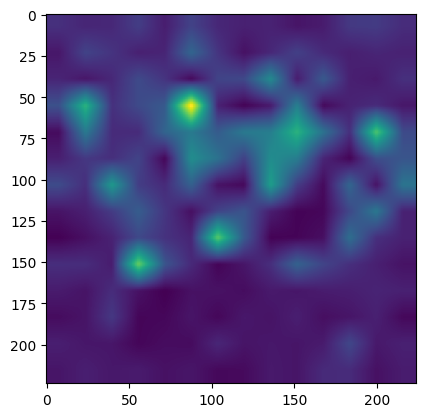

In [380]:
attention_maps = clf_att.mean(dim=1)
attention_maps = attention_maps.view(-1, 14, 14)
plt.imshow(attention_maps[0])
attention_maps = attention_maps.unsqueeze(1)
print(attention_maps.shape)
print(attention_maps.shape)
attention_maps = F.interpolate(attention_maps, size=(224, 224), mode='bilinear', align_corners=False)
attention_maps = attention_maps.squeeze(1)#.mean(0)
print(attention_maps.shape)
plt.imshow(attention_maps[0])

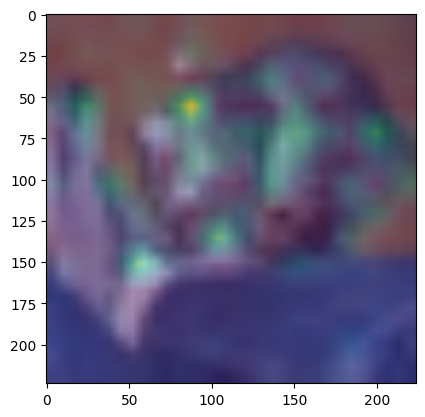

In [381]:
plt.imshow(im)
plt.imshow(attention_maps[0], alpha=0.5)

In [37]:
x = torch.randn(size = (1, 3, 224, 224), device = device)

In [61]:
%%timeit -n 100
vit(x)

9.41 ms ± 78.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
%%timeit -n 100
vit.forward_svd(x)

11.9 ms ± 526 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
